# ABOUT


Datascientest's Datascientist continuous bootcamp - cohorte Mars2022 -  AeroBOT project

**Tutor**

* Alban THUET

**Authors:**

* Hélène ASSIR
* Hichem HADJI  
* [Ioannis STASINOPOULOS](https://www.linkedin.com/in/ioannis-stasinopoulos/)

</br>

---
</br>

**Version History**

Version | Date       | Author(s)  | Modification
--------|----------- | ---------  | --------------------------
X.X     | XX/XX/2022 | A.B        | modif
1.1     | 04/07/2022 | I.S, H.A.  | Anomaly one-hot encoding
1.0     | 30/06/2022 | I.S, H.A.  | Document creation

This notebook can be executed entirely. 

It

* mounts the GDrive of our AeroBot project @gmail account.

* loads the data from the `train_data_final.pkl` file (cf. `0_test_set_creator_DO_NOT_MODIFY_20220630.ipynb`) under a pandas DataFrame named `df`, which contains `97417` entries and 96 columns.
These data do not contain any more UAS-related entries.

* Performs Feature Engineering: one-hot-encoding of Anomaly using a naive approache, looking directly for the root label into the multiple modalities string of Anomaly
* A comparison of 2 approaches (Naive vs Regex, more complex) was performed, but, with very limited discrepancies between the 2 approaches, we favored the naive one (see : ATTEMPT_1_main_DO_NOT_MODIFY_20220704_Anomaly_ReGex.ipynb).  

Further processing of the data should be perfomed on this dataframe, after having **copied a version of the present notebook**.

# IMPORT PACKAGES


settings for  full / patial Narrative display. Helene?


In [ ]:
#######################
# Import packages
#######################
import numpy as np
import seaborn as sns

#######################
# Pandas
#######################
import pandas as pd
# Set pandas settings to show all data when using .head(), .columns etc.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option("display.colheader_justify","left") # left-justify the print output of pandas

### Display full columnwidth
# Set pandas settings to display full text columns
#pd.options.display.max_colwidth = None
# Restore pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

import itertools # Pour créer des iterateurs

# Package to show the progression of pandas operations
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
# simply use .progress_apply() instead of .apply() on your pd.DataFram

######################
# PLOTTING
######################
import matplotlib.pyplot as plt
%matplotlib inline
# Define global plot parameters for better readability and consistency among plots
# A complete list of the rcParams keys can be retrieved via plt.rcParams.keys() function
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 23
plt.rcParams['xtick.labelsize'] = 23
plt.rcParams['ytick.labelsize'] = 23
plt.rc('legend', fontsize=23)    # legend fontsize

# BOKEH 
from bokeh.plotting import figure # Importation de la classe figure qui permet de créer un graphique bokeh.
from bokeh.io import  push_notebook, output_notebook, show
output_notebook() # permet d'afficher tous les futurs graphiques dans l'output d'une cellule jupyter. Si cette instruction n'est pas lancée, la figure s'affichera dans un nouvel onglet.
from bokeh.models import ColumnDataSource
from bokeh.transform import dodge
from bokeh.models.tools import HoverTool

#####################
# NLP 
#####################
import re # for Regular Expression handling
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('omw-1.4') # necessary for WordNet lemmatizer
from nltk.tokenize import word_tokenize # Usual tokenizer
from nltk.tokenize import TweetTokenizer # Special tokenizer;  "we'll", "didn't", etc. are considered as one word
from sklearn.feature_extraction.text import CountVectorizer # Vectorization
from nltk.corpus import stopwords # Import stopwords from nltk.corpus
from nltk.stem.snowball import EnglishStemmer

###############################
# ML preprocessing and models
###############################
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, confusion_matrix

import pickle as pkl # Saving data externally

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# LOAD DATA

## Mount GDrive

In [ ]:
#@title
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


'/content'

In [ ]:
#@title
# move to the transformed data location (you can create a deeper structure, if needed, e.g. to save a trained model):
%cd /content/drive/MyDrive/data/transformed/

/content/drive/MyDrive/data/transformed


In [ ]:
#@title
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

'Copy of Qualified abbreviations_20220718.xlsx.gsheet'
'Data Dictionnary.xlsx'
 Narrative_PP_stemmed_24072022_TRAIN.pkl
 Narrative_Raw_Stemmed_24072022_TRAIN.pkl
 Narrative_RegEx_subst_21072022_TRAIN.pkl
'Qualified abbreviations_20220707_test.csv'
'Qualified abbreviations_20220708.csv'
'Qualified abbreviations_20220718.csv'
'Qualified abbreviations_20220718_Google_sheet.gsheet'
 test_data_final.pkl
 train_data_final.pkl


## Load data from .pkl file


In [ ]:
#@title
# Load the TRAIN data (97417 entries)
# Do not touch the TEST data until the end of the project!
# or the curse of the greek gods will fall upon you!

%cd /content/drive/MyDrive/data/transformed/
with open("train_data_final.pkl", "rb") as f:
    loaded_data = pkl.load(f)

df = loaded_data[0]
print("\nA Dataframe with", len(df), "entries has been loaded")

/content/drive/MyDrive/data/transformed

A Dataframe with 97417 entries has been loaded


# NARRATIVE ENGINEERING

### Load the pre-processed Narrative data 

See the notebook that performs the substitutions

In [ ]:
# Load the file Narrative_PP_stemmed_21072022_TRAIN.pkl
%cd /content/drive/MyDrive/data/transformed/
with open("Narrative_PP_stemmed_24072022_TRAIN.pkl", "rb") as f:
    loaded_narr = pkl.load(f)

df['Narrative_PP_stemmed'] = loaded_narr[0]
print("Data loaded")

/content/drive/MyDrive/data/transformed
Data loaded


In [ ]:
# Load the file Narrative_PP_stemmed_21072022_TRAIN.pkl
%cd /content/drive/MyDrive/data/transformed/
with open("Narrative_Raw_Stemmed_24072022_TRAIN.pkl", "rb") as f:
    loaded_narr = pkl.load(f)

df['Narrative_Raw_Stemmed'] = loaded_narr[0]
print("Data loaded")

/content/drive/MyDrive/data/transformed
Data loaded


In [ ]:
df.loc[1715282]['Narrative']

"I am writing this report to bring attention to the second departure frequency out of MDW last night. It is a safety issue to give us two frequency changes below 3;000 feet on departure out of MDW.We were in a heavy [aircraft] doing a full power; flaps 25; bleeds off takeoff off of 22L. These takeoffs are known to have very high climb rates; so the intermediate level-off of 3;000 feet approaches fast. At 1;000 feet; we're instructed to contact Departure on 128.2. Simultaneously; I switch frequencies and retract flaps as commanded by the pilot flying. Upon checking in with 128.2; he instructs us to climb and maintain 4;000 feet and subsequently contact 126.62. I dial in 4;000 feet and continue to retract flaps while monitoring a level-off from a climb rate of over 2;000 FPM. At this point; my head turns down to the radio to dial the new Departure frequency in. I check in and they tell us to climb and maintain 12;000 feet. I dial in 12;000 feet; confirm it; reset the autobrake and gear l

In [ ]:
df.loc[1715282]['Narrative_PP_stemmed'][:20]

['write',
 'report',
 'bring',
 'attent',
 'second',
 'departur',
 'frequenc',
 'mdw',
 'last',
 'night',
 'safeti',
 'issu',
 'give',
 'us',
 'two',
 'frequenc',
 'chang',
 '3',
 '000',
 'feet']

In [ ]:
df.loc[1715282]['Narrative_Raw_Stemmed'][:20]

['write',
 'report',
 'bring',
 'attent',
 'second',
 'departur',
 'frequenc',
 'mdw',
 'last',
 'night',
 'safeti',
 'issu',
 'give',
 'us',
 'two',
 'frequenc',
 'chang',
 '3',
 '000',
 'feet']

## Metrics on vocabulary

size (#words), absolute frequencies, document frequencies...

- See the impact of our Narrative preprocessing
- New contractions may appear : To be added to our Contractions list with full-text replacement

In [ ]:
def CountVectorizer_AeroBOT(narratives):
  """
  Custom CountVectorizer with dummy tokenizer and preprocessor,
  that does not preprocess the data.
  Note that this also deactivates the built-in 'analyzer'
  
  Input: pd.Series, each element is a list of tokens
  Return: 
  [0]: sparse matrix as scipy.sparse.csr_matrix object
  [1]: vocabulary
  [2]: vocabulary length (int)
  [3]: vectorizer as sklearn.feature_extraction.text.CountVectorizer object
  """
  
  # Define dummy functions to override the CountVectorizer's preprocessing built-in functions
  # This allows us to pass each narrative as a list of tokens
  # and thus use OUR preprocessing pipeline
  # see also https://scikit-learn.org/stable/modules/feature_extraction.html#
  def dummy_tokenizer(s):
    return s

  def dummy_preprocessor(s):
    return s

  # Instantiate the vectorizer with dummy functions
  vectorizer = CountVectorizer(preprocessor = dummy_preprocessor, 
                              tokenizer = dummy_tokenizer,
                              analyzer = 'word') 

  # Sparse matrix
  spm = vectorizer.fit_transform(narratives) # scipy.sparse.csr_matrix object
  # Compressed Sparse Row matrix

  # Vocabulary
  vocab = vectorizer.get_feature_names_out()
  # ordered by the word indices

  print(f"{spm.get_shape()[0]} tokenized texts have been vectorized")
  print(f"Vocabulary length: {len(vectorizer.get_feature_names_out())}")
  
  return spm, vocab, len(vectorizer.get_feature_names_out()), vectorizer

In [ ]:
# # Call the function
# spm, vocab, _, _ = CountVectorizer_AeroBOT(df['Narrative_Raw_Stemmed'])

In [ ]:
# sentence = ''
# for word in df['Narrative_Raw_Stemmed'].iloc[0]:
#   sentence = sentence + ' ' + word
# sentence

### Try with single string instead of list of tokens

In [ ]:
# Join all tokens into a single string
df['Narrative_Raw_Stemmed_str'] = df['Narrative_Raw_Stemmed'].apply(lambda token_list: ' '.join(entry for entry in token_list))

# Instantiate the vectorizer with default settings
vectorizer = CountVectorizer() 

# Sparse matrix
spm = vectorizer.fit_transform(df['Narrative_Raw_Stemmed_str']) # scipy.sparse.csr_matrix object
# Compressed Sparse Row matrix

# Instantiate a second CountVectorizer with the the binary = True option 
vectorizer_bool = CountVectorizer(binary = True) # all non zero counts are set to 1

# Sparse matrix in boolean form
spm_bool = vectorizer_bool.fit_transform(df['Narrative_Raw_Stemmed_str'])

In [ ]:
# Vocabulary
vocab = vectorizer.get_feature_names_out()
# ordered by the word indices
print(f"Vocabulary length: {len(vectorizer.get_feature_names_out())}")

Vocabulary length: 57732


### [Sandbox] Play with sparse matrix

In [ ]:
#@title
print("Number of stored values, including explicit zeros:", spm.nnz)

Number of stored values, including explicit zeros: 8658423


In [ ]:
#@title
spm.count_nonzero()
# Unlike getnnz() and the nnz property, which return the number of stored entries (the length of the data attribute), this method counts the actual number of non-zero entries in data.

8658423

#### Calculate the DOCUMENT and ABSOLUTE frequency (in all the corpus)

In [ ]:
#@title
# Get the index of 'aircraft'
aircraft_idx = vectorizer.vocabulary_['aircraft']

In [ ]:
#@title
# calculate the document frequency
np.count_nonzero(spm.getcol(aircraft_idx).asformat("array"))

36482

In [ ]:
#@title
# calculate the absolute frequency
spm.getcol(aircraft_idx).sum()

150225

In [ ]:
#@title
spm.get_shape()
# number of columns = vocab length
# number of rows = len(df)

(97417, 57732)

In [ ]:
#@title
spm.get_shape()[0] * spm.get_shape()[1] 
# Why isn't this equal to the number of stored values?

5624078244

In [ ]:
#@title
# CSR format data array of the matrix
print(spm.data)
# I don't get what this is ?

[2 2 1 ... 1 1 2]


In [ ]:
#@title
## /!\ This explodes RAM
#spm.asformat("array")

### Plot word occurences

The sparse matrix is a very memory-greedy object and causes RAM crash when we wish to cast it to an array and visualize it.

Therefore, to obtain the word occurences, we call the sparse matrix column-by-column, i.e. word-by-word using its built-in methods.

In [ ]:
def get_word_occurence(spm, vectorizer):
  """
  Inputs: 
  - sparse matrix as scipy.sparse.csr_matrix object
  If the sparse matrix is in boolean form, you will get the DOCUMENT frequency
  - vectorizer object

  Return a df with:
  column 'token' = vocab word
  column 'word_idx' = vocabulary index of the word
  column 'occurence' = word occurence (absolute or document frequency, depending on inputs passed)
  """

  # Get the vocabulary directly from the vectorizer object
  vocab = vectorizer.get_feature_names_out()

  # Calculate the occurence:
  # perform the sum on the sparse matrix and transform it to an array:
  occurence = np.asarray(spm.sum(axis=0)).ravel()

  # Write data into a DataFrame
  # The df.index are the words
  word_occ_df = pd.DataFrame(occurence, index = vocab, columns = ['occurence'])

  # Copy the df.index (i.e. the words) into a new column
  word_occ_df['word_idx'] = word_occ_df.index
  # Get the vocab index of each word into a new column
  word_occ_df['word_idx'] = word_occ_df['word_idx'].apply(lambda x: vectorizer.vocabulary_[x])

  # Reorder columns
  word_occ_df = word_occ_df[['word_idx', 'occurence']]

  # Reset index
  word_occ_df = word_occ_df.reset_index().rename(columns = {'index': 'token'})
  word_occ_df

  return word_occ_df

In [ ]:
def get_abs_doc_frequ(spm, spm_bool, vectorizer, vectorizer_bool):
  """
  Calculate absolute frequency and document frequency
  Input: sparse matrix and vectorizer object in 'normal' and boolean form, i.e.
  using the option 'CountVectorizer(binary = True)'

  Return a DataFrame with token, token_id, absolute and document frequency
  """

  # Create absolute and document frequency DataFrames
  word_ABS_frequ = get_word_occurence(spm, vectorizer)
  word_DOC_frequ = get_word_occurence(spm_bool, vectorizer_bool)

  # Merge dataframes
  word_frequencies = word_ABS_frequ.merge(word_DOC_frequ, on = 'token', how = 'left')

  # Check that the two DataFrames have identical length and that two columns are identical
  if (len(word_ABS_frequ) == len(word_DOC_frequ)) & (sum(word_frequencies['word_idx_x'] != word_frequencies['word_idx_y']) == 0):
    print("Merge successful on column 'token'\n")

  else:
    print('There is an inconsistency among the two word indices!')

  # Drop unnecessary columns and rename columns
  word_frequencies = word_frequencies.drop(columns = ['word_idx_y'])
  word_frequencies = word_frequencies.rename(columns = {'word_idx_x': 'token_id', 'occurence_x': 'abs_frequ', 'occurence_y': 'doc_frequ'})

  return word_frequencies

In [ ]:
get_abs_doc_frequ(spm, spm_bool, vectorizer, vectorizer_bool).sort_values(by = 'abs_frequ', ascending = False).head(100)

#### Plot

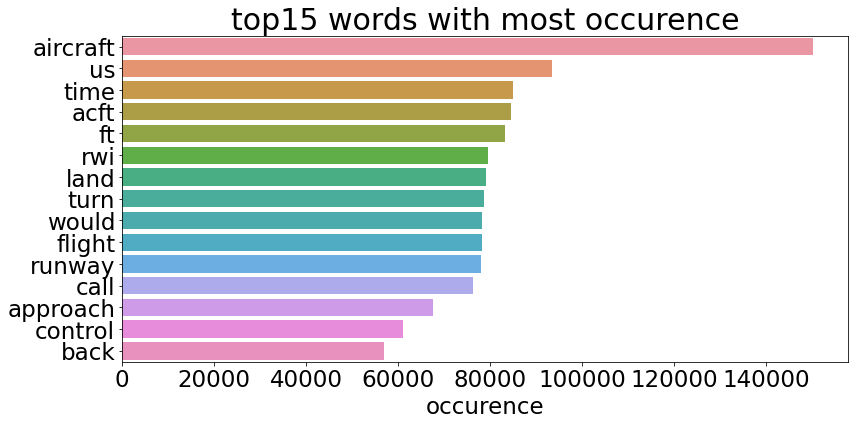

In [ ]:
# Plot the top X occurences
topX = 15

fig = plt.figure(figsize = (13,6))
plt.ylim(topX - 0.5)
plt.xlabel('Count')
plt.title(f"top{topX} words with most occurence")
sns.barplot(data = word_occ_df[:topX], y = word_occ_df.index[:topX], x = 'occurence');

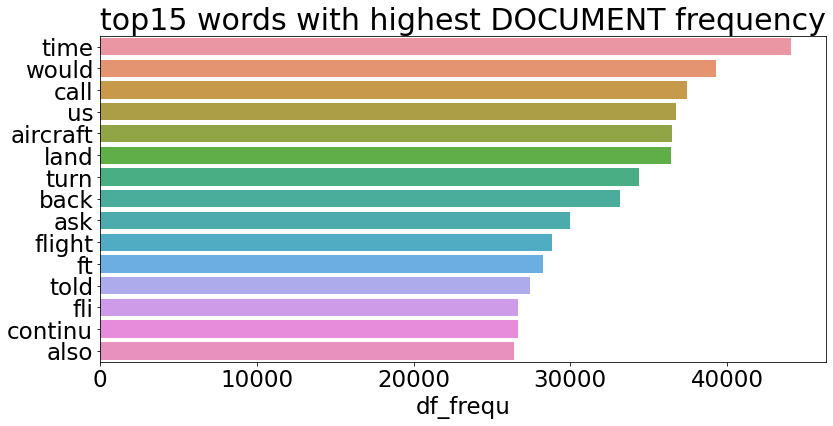

In [ ]:
# Plot the top X DOCUMENT frequency occurences
# Sort by highest DOCUMENT frequency
word_occ_df_sorted = word_occ_df.sort_values(by = 'df_frequ', ascending = False)

topX = 15

fig = plt.figure(figsize = (13,6))
plt.ylim(topX - 0.5)
plt.xlabel('Count')
plt.title(f"top{topX} words with highest DOCUMENT frequency")
sns.barplot(data = word_occ_df_sorted[:topX], y = word_occ_df_sorted.index[:topX], x = 'df_frequ');

### Preprocessed narratives (default CountVectorizer settings)

In [ ]:
# Join all tokens into a single string
df['Narrative_PP_stemmed_str'] = df['Narrative_PP_stemmed'].apply(lambda token_list: ' '.join(entry for entry in token_list))

In [ ]:


# Instantiate the vectorizer
vectorizer = CountVectorizer() 

# Sparse matrix
spm = vectorizer.fit_transform(df['Narrative_PP_stemmed_str']) # scipy.sparse.csr_matrix object
# Compressed Sparse Row matrix

# Vocabulary
vocab = vectorizer.get_feature_names_out()
# ordered by the word indices
print(f"Vocabulary length: {len(vectorizer.get_feature_names_out())}")

# Instantiate a second CountVectorizer with the the binary = True option 
vectorizer_bool = CountVectorizer(binary = True) # all non zero counts are set to 1

# Sparse matrix in boolean form
spm_bool = vectorizer_bool.fit_transform(df['Narrative_PP_stemmed_str'])

Vocabulary length: 55878


In [ ]:
get_abs_doc_frequ(spm, spm_bool, vectorizer, vectorizer_bool).sort_values(by = 'abs_frequ', ascending = False).head(100)

Merge successful on column 'token'



,token,word_id,abs_frequ,doc_frequ
12045,aircraft,12045,233877,62623
44075,runway,44075,214363,43922
24348,feet,24348,141647,44452
24822,flight,24822,113393,45512
32414,land,32414,105066,44433
13004,approach,13004,103289,35710
18885,control,18885,93891,37540
51506,us,51506,93336,36745
49167,time,49167,85020,44092
50163,turn,50163,78599,34384


### Preprocessed narratives (no numbers RegEx setting)

In [ ]:
# Join all tokens into a single string
df['Narrative_PP_stemmed_str'] = df['Narrative_PP_stemmed'].apply(lambda token_list: ' '.join(entry for entry in token_list))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Instantiate the vectorizer that IGNORES NUMBERS and UNDERSCORES
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b") 
# the default RegEx is: "\b\w\w+\b"
# reminder: \w = [a-zA-Z0-9_]
# That means it finds anything of length 2 or longer that has word boundaries, 
# which are any punctuation or white spaces, and matches w. 
# This includes any numbers. Numbers can be at the beginning of the word, 
# the middle of the word or it can be just all numbers.

# Sparse matrix
spm_PP = vectorizer.fit_transform(df['Narrative_PP_stemmed_str']) # scipy.sparse.csr_matrix object
# Compressed Sparse Row matrix


# Vocabulary
vocab_PP = vectorizer.get_feature_names_out()
# ordered by the word indices
print(f"Vocabulary length: {len(vectorizer.get_feature_names_out())}")

Do the same as above, on the **preprocessed** narratives

In [ ]:
# # Call the function
# spm_PP, vocab_PP, _, _ = CountVectorizer_AeroBOT(df['Narrative_PP_stemmed'])

In [ ]:
# Join all tokens into a single string
df['Narrative_PP_stemmed_str'] = df['Narrative_PP_stemmed'].apply(lambda token_list: ' '.join(entry for entry in token_list))

# Instantiate the vectorizer that IGNORES NUMBERS and UNDERSCORES
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b") 
# the default RegEx is: "\b\w\w+\b"
# reminder: \w = [a-zA-Z0-9_]
# That means it finds anything of length 2 or longer that has word boundaries, 
# which are any punctuation or white spaces, and matches w. 
# This includes any numbers. Numbers can be at the beginning of the word, 
# the middle of the word or it can be just all numbers.

# Sparse matrix
spm_PP = vectorizer.fit_transform(df['Narrative_PP_stemmed_str']) # scipy.sparse.csr_matrix object
# Compressed Sparse Row matrix


# Vocabulary
vocab_PP = vectorizer.get_feature_names_out()
# ordered by the word indices
print(f"Vocabulary length: {len(vectorizer.get_feature_names_out())}")

Vocabulary length: 40034


In [ ]:
vocab_PP[:10]

array(['aa', 'aaa', 'aaaa', 'aaaaa', 'aaab', 'aab', 'aaba', 'aabb',
       'aabc', 'aabe'], dtype=object)

In [ ]:
word_occ_df_PP = get_word_occurence(spm_PP, vocab_PP, vectorizer)
word_occ_df_PP.head()

100%|██████████| 40034/40034 [22:09<00:00, 30.11it/s]


,word_idx,occurence,df_frequ
aircraft,832,233877,62623
runway,30051,214363,43922
feet,12131,141647,44452
flight,12590,113393,45512
land,19452,105066,44433


#### Plot

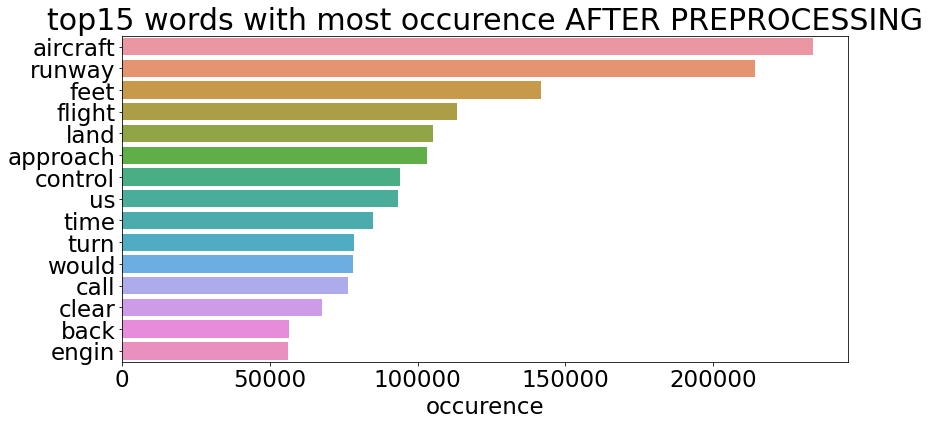

In [ ]:
# Plot the top X occurences
topX = 15

fig = plt.figure(figsize = (13,6))
plt.ylim(topX - 0.5)
plt.xlabel('Count')
plt.title(f"top{topX} words with most occurence AFTER PREPROCESSING")
sns.barplot(data = word_occ_df_PP[:topX], y = word_occ_df_PP.index[:topX], x = 'occurence');

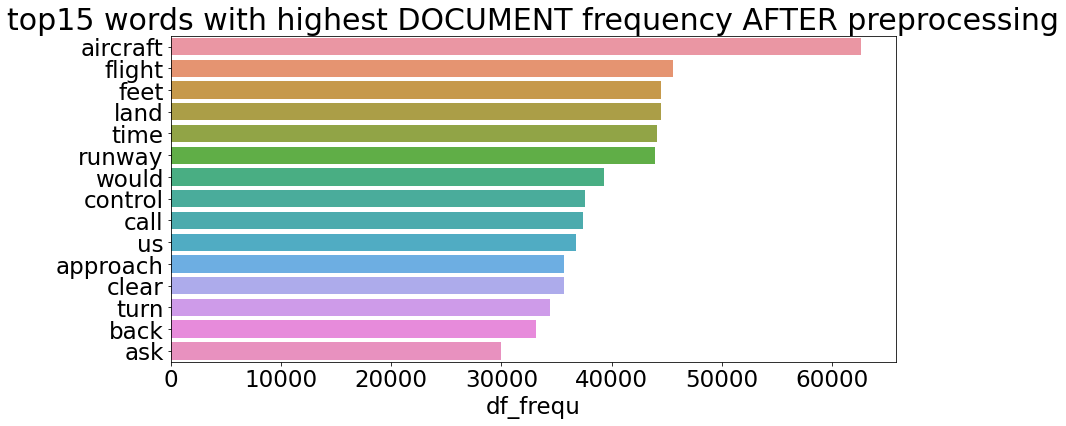

In [ ]:
# Plot the top X DOCUMENT frequency occurences
# Sort by highest DOCUMENT frequency
word_occ_df_PP_sorted = word_occ_df_PP.sort_values(by = 'df_frequ', ascending = False)

topX = 15

fig = plt.figure(figsize = (13,6))
plt.ylim(topX - 0.5)
plt.xlabel('Count')
plt.title(f"top{topX} words with highest DOCUMENT frequency AFTER preprocessing")
sns.barplot(data = word_occ_df_PP_sorted[:topX], y = word_occ_df_PP_sorted.index[:topX], x = 'df_frequ');

In [ ]:
# # BOKEH FIGURE [DRAFT]

# # from bokeh.plotting import figure # Importation de la classe figure qui permet de créer un graphique bokeh.
# # from bokeh.io import  push_notebook, output_notebook, show
# #output_notebook() # permet d'afficher tous les futurs graphiques dans l'output d'une cellule jupyter. Si cette instruction n'est pas lancée, la figure s'affichera dans un nouvel onglet.

# f = figure(
#     title = 'Title',
#     width = 500,
#     height = 400 )


# # Creation d'une source
# source = ColumnDataSource(word_occ_df_PP)

# f.circle('occurence',                          
#         'df_frequ',
#           #color = 'red',          # couleur des points 
#           #hover_color = 'blue',   # couleur du point survolé par la souris.
#           #hover_alpha = 0.5      # opacité du point survolé par la souris.
#         )
# show(f)

In [ ]:
fig = plt.figure(figsize = (13,10))
plt.scatter(word_occ_df_PP['occurence']/1000, word_occ_df_PP['df_frequ']/1000)
plt.xlabel('absolute frequ (thousands)')
plt.ylabel('document frequ (thousands)');

# Make a BOKE

NameError: ignored

<Figure size 936x720 with 0 Axes>

In [ ]:
word_occ_df_PP.head()

,word_idx,occurence,df_frequ
aircraft,832,233877,62623
runway,30051,214363,43922
feet,12131,141647,44452
flight,12590,113393,45512
land,19452,105066,44433


### Other

Analyze the Vocabulary

In [ ]:
def sort_dict(my_dict):
  """
  Return sorted dictionnary
  """
  sorted_dict = {k: v for k, v in sorted(my_dict.items(), reverse = False, key = lambda item: item[1])}
  # A custom key function in form of a lambda function is supplied to customize the sort order:
  # item[1] means we sort by the value of the my_dict.items()
  # item[0] means we sort by the key   of the my_dict.items()

  return sorted_dict

In [ ]:
# Return alphabetically-sorted tokens. 
# Each token has is code-number (it’s not its frequency)
sort_dict(vectorizer.vocabulary_)
# for just the vocabulary without the position of the word in the sparse matrix, use ‘get_feature_names_out()’

In [ ]:
# you can also transform the vocab dictionnary into a list, to be able to slice it
list(sort_dict(vectorizer.vocabulary_))[:10]